In [336]:
import os
import random
import uuid
from glob import glob
from pathlib import Path

import albumentations as A
import catalyst
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from albumentations.pytorch import ToTensor
from catalyst.callbacks.checkpoint import CheckpointCallback
from catalyst.callbacks.early_stop import EarlyStoppingCallback
from catalyst.callbacks.metrics.ppv_tpr_f1 import \
    PrecisionRecallF1ScoreCallback
from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback
from scipy.stats.mstats import gmean
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedKFold
from PIL import Image
import matplotlib.pyplot as plt


def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 36
seed_torch(SEED)

In [337]:
def get_model():
    model = torchvision.models.resnet34(pretrained=True, progress=True)
    return model

In [362]:
class GradCam:
    def __init__(self, feature_layer, classifier_layer, transforms, shadow=False):
        self.feature_layer = feature_layer.eval()
        self.classifier_layer = classifier_layer.eval()
        self.transforms = transforms
        self.shadow = shadow
        
        
    def _toHeatmap(self, L, shadow=False):
        """
        x: ndarray (H, W)
        """
        if shadow:
            L = np.uint8(L*255)[..., None]
            L = np.concatenate([L, L, L], 2)
        else:
            L = cv2.applyColorMap(255-np.uint8(L*255), cv2.COLORMAP_JET)
        return np.asarray(L)
        
        
    def __call__(self, img):
        img = self.transforms(img)
        img = img[None, ...]
        
        feature_output = self.feature_layer(img)
        classifier_output = self.classifier_layer(feature_output)

        feature_output.retain_grad()
        classifier_output[0][torch.argmax(classifier_output[0])].backward()  
        
        feature_output_grad_size = feature_output.grad.size()
        alpha = torch.mean(feature_output.grad.view(
            feature_output_grad_size[1],
            feature_output_grad_size[2]*feature_output_grad_size[3]), 1)
        L = nn.functional.relu(
            torch.sum(
                feature_output.view(
                    feature_output_grad_size[1],
                    feature_output_grad_size[2],
                    feature_output_grad_size[3]
                )*alpha.view(
                    feature_output.size(1), 1, 1
                ), 0
            )
        ).cpu().detach().numpy()
        L = (L - L.min())/L.max()
        L = cv2.resize(L, (224, 224))
        L = self._toHeatmap(L, self.shadow)
        return L

In [363]:
model = get_model()

transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor()
    ])


feature_layer = nn.Sequential(*list(model.children())[:-2])
classifier_layer = nn.Sequential(*[model.avgpool, nn.Flatten(1), model.fc])

grad_cam = GradCam(feature_layer, classifier_layer, transforms, shadow=True)

In [364]:
img = cv2.imread('/kaggle/input/sample-cat/cat.jpg')
img = cv2.resize(img, (224, 224))
mask = grad_cam(img)

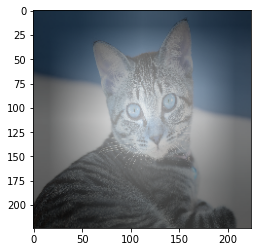

In [365]:
plt.imshow(np.uint8(0.7*mask + 0.3*img))